In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test_supplement.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv


In [2]:
df = pd.read_csv("/kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv")
df.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


# TalkingData: Fraudulent Click Prediction






The analysis is divided into the following sections:
- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost
- Modelling building and evaluation: Gradient Boosting
- Modelling building and evaluation: XGBoost


## Understanding the Business Problem

<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, I will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). 

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [3]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [16]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = False
if testing:
    train_path = "/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)


In [5]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,33924,15,1,19,111,2017-11-09 04:03:08,0
1,37383,3,1,13,280,2017-11-09 04:03:08,0
2,56758,15,1,10,245,2017-11-09 04:03:08,0
3,7722,9,1,25,145,2017-11-09 04:03:08,0
4,7811,15,1,13,430,2017-11-09 04:03:08,0


In [6]:
train_sample.shape

(10000000, 7)

In [7]:
# Displays memory consumed by each column ---
print(train_sample.memory_usage())

Index                 128
ip               20000000
app              20000000
device           20000000
os               20000000
channel          20000000
click_time       80000000
is_attributed    10000000
dtype: int64


## Exploring the Data - Univariate Analysis

Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [8]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ip             uint16
 1   app            uint16
 2   device         uint16
 3   os             uint16
 4   channel        uint16
 5   click_time     object
 6   is_attributed  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 181.2+ MB


In [9]:
# Basic exploratory analysis 

# Number of unique values in each column
def fraction_unique(x):
    return train_sample[x].nunique()

number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'ip': 45828,
 'app': 331,
 'device': 1064,
 'os': 261,
 'channel': 174,
 'click_time': 9508,
 'is_attributed': 2}

In [10]:
# All columns apart from click time are originally int type, 
# though note that they are all actually categorical 
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

There are certain 'apps' which have quite high number of instances/rows (each row is a click). The plot below shows this.

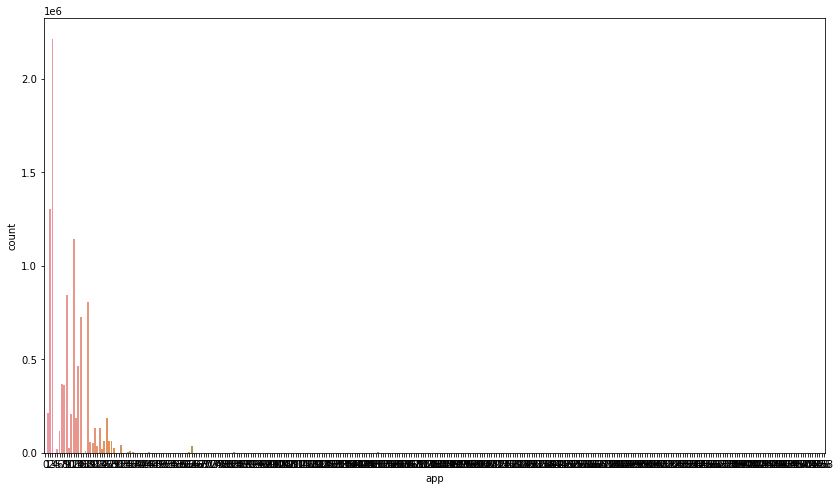

In [11]:
# # distribution of 'app' 
# # some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)
plt.show()

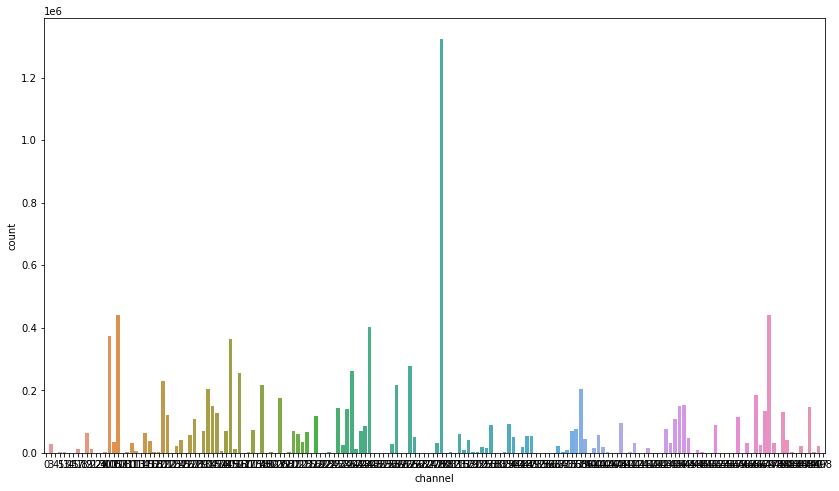

In [12]:
# # channel: various channels get clicks in comparable quantities
plt.figure(figsize=(14, 8))
sns.countplot(x="channel", data=train_sample)
plt.show()

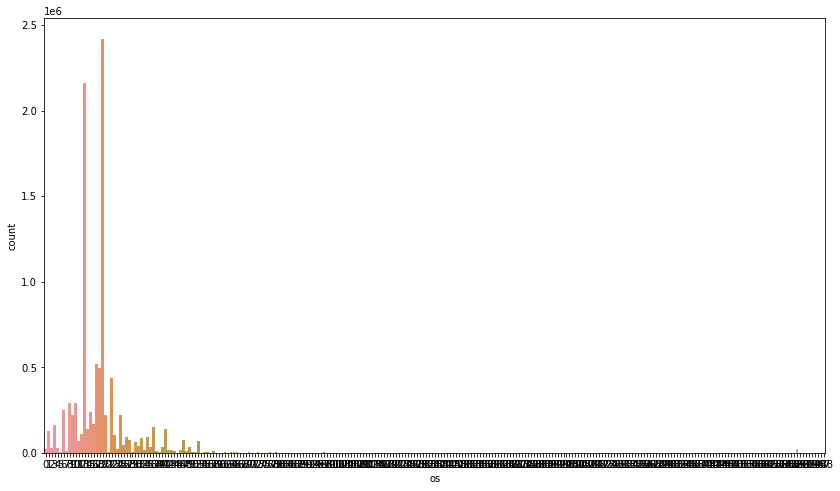

In [13]:
# # os: there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)
plt.show()

Let's now look at the distribution of the target variable 'is_attributed'.

In [14]:
# # target variable distribution
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.75386
1     0.24614
Name: is_attributed, dtype: float64

Only about **0.2%** of clicks are 'fraudulent', which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

### Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [15]:
# plot the average of 'is_attributed', or 'download rate'
# with app (clearly this is non-readable)
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
0,0.394495,218
1,0.000223,210983
2,0.000191,1302949
3,0.000324,2216338
4,0.000000,1310
...,...,...
742,0.000000,1
753,0.000000,1
755,0.000000,1


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [16]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,210983,32451,1,3,135,2017-11-09 04:03:08,0
1,1,210983,11347,1,19,124,2017-11-09 04:03:08,0
2,1,210983,39827,1,30,349,2017-11-09 04:03:08,0
3,1,210983,28383,1,6,439,2017-11-09 04:03:08,0
4,1,210983,35114,1,18,137,2017-11-09 04:03:08,0


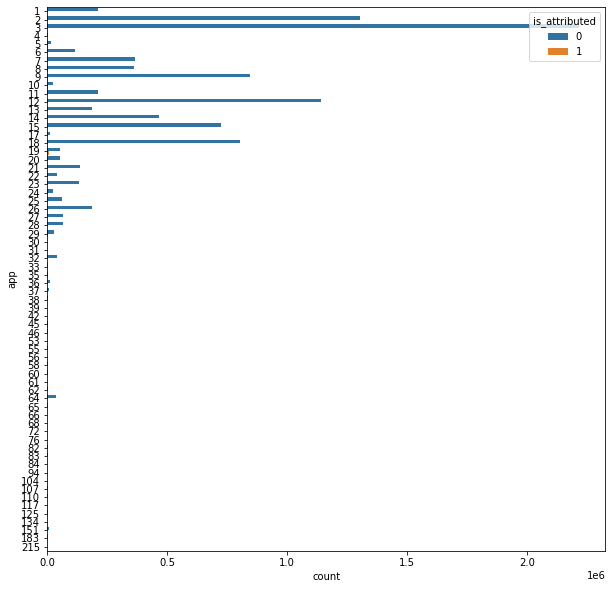

In [17]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data = frequent_apps);

## Feature Engineering

Let's derive some new features from the existing ones. There are a number of features one can extract from click_time itself, and by grouping combinations of IP with other features.

### Datetime Based Features

In [8]:
# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df
def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df["day_of_year"] = df["datetime"].dt.dayofyear
    df["month"] = df["datetime"].dt.month
    df["hour"] = df["datetime"].dt.hour
    return df

In [17]:
# creating new datetime variables and dropping the old ones
train_sample = timeFeatures(train_sample)
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,33924,15,1,19,111,0,3,313,11,4
1,37383,3,1,13,280,0,3,313,11,4
2,56758,15,1,10,245,0,3,313,11,4
3,7722,9,1,25,145,0,3,313,11,4
4,7811,15,1,13,430,0,3,313,11,4


In [20]:
# datatypes
# note that by default the new datetime variables are int64
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [18]:
# lets convert the variables back to lower dtype again
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

### IP Grouping Based Features

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

In [22]:
# number of clicks by count of IP address
# note that we are explicitly asking pandas to re-encode the aggregated features 
# as 'int16' to save memory
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,1,200
1,2,1
2,3,2
3,4,155
4,5,11


I will now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc.

The following function takes in a dataframe and creates these features.

In [9]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df.groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).size().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [19]:
train_sample = grouped_features(train_sample)

In [25]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,33924,15,1,19,111,0,3,313,11,4,659,221,1,59,17,179
1,37383,3,1,13,280,0,3,313,11,4,633,303,36,101,67,301
2,56758,15,1,10,245,0,3,313,11,4,404,258,6,35,21,258
3,7722,9,1,25,145,0,3,313,11,4,133,56,1,8,5,56
4,7811,15,1,13,430,0,3,313,11,4,178,42,1,22,3,42


In [20]:
gc.collect()

93

## Modelling

In [21]:
# Handling Categorical Variables

categorical_cols = ['ip','app','device','os','channel']
le = LabelEncoder()
train_sample[categorical_cols]=train_sample[categorical_cols].apply(lambda x: le.fit_transform(x))

In [22]:
# create x and y train
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

# split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000000, 15)
(8000000, 1)
(2000000, 15)
(2000000, 1)


## XGBoost

In [23]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

[11:24:53] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [24]:
# make predictions for validatin data
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.99677181e-01, 3.22809909e-04],
       [9.99986947e-01, 1.30268045e-05],
       [9.98381197e-01, 1.61877938e-03],
       [9.99038160e-01, 9.61823505e-04],
       [9.99894023e-01, 1.05989624e-04],
       [9.99931693e-01, 6.82879981e-05],
       [9.99894142e-01, 1.05847415e-04],
       [9.99919832e-01, 8.01674687e-05],
       [9.99166727e-01, 8.33263970e-04],
       [9.99915361e-01, 8.46253897e-05]], dtype=float32)

In [25]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 96.82%


The roc_auc in this case is about 97% with default hyperparameters. Let's try changing the hyperparameters.
Let's now try tuning the hyperparameters using k-fold CV through grid search CV to find the optimal values of hyperparameters.

In [35]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.4], 
             'subsample': [0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs=-1,
                        return_train_score=True)      



In [36]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 158.1min finished


[08:23:21] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [37]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2904.877864,13.573965,19.255065,0.336167,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.955268,0.951580,0.954783,0.953877,0.001636,3,0.954119,0.955358,0.954674,0.954717,0.000507
1,3163.534182,60.000429,19.864798,0.251761,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.954839,0.951294,0.953814,0.953316,0.001490,4,0.953545,0.954903,0.953551,0.953999,0.000639
2,3000.714184,30.352856,21.202605,0.264289,0.4,0.6,"{'learning_rate': 0.4, 'subsample': 0.6}",0.958416,0.955038,0.958333,0.957263,0.001573,1,0.958239,0.959896,0.958990,0.959042,0.000677
3,3195.788170,17.228816,19.010578,0.354274,0.4,0.9,"{'learning_rate': 0.4, 'subsample': 0.9}",0.958233,0.954655,0.957964,0.956950,0.001627,2,0.958042,0.959692,0.957993,0.958576,0.000789


In [38]:
model_cv.best_score_

0.9572625180517315

Since the XGBoost gives the highest score with default parameters, lets run the test data on the same

In [26]:
# feature importance
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.008940837,
 'app': 0.19421373,
 'device': 0.06140361,
 'os': 0.023961289,
 'channel': 0.13618907,
 'day_of_week': 0.0,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.010273933,
 'ip_count': 0.05421346,
 'ip_day_hour': 0.01384524,
 'ip_hour_channel': 0.02153351,
 'ip_hour_os': 0.06759132,
 'ip_hour_app': 0.07374049,
 'ip_hour_device': 0.33409348}

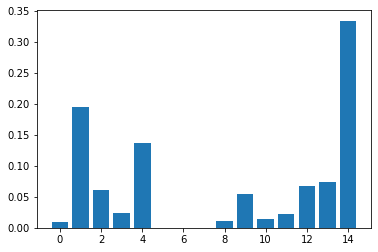

In [27]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

## Test Data

In [28]:
test = pd.read_csv("/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv",nrows=5000000)
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [29]:
test.shape

(5000000, 7)

In [30]:
test.dtypes

click_id       int64
ip             int64
app            int64
device         int64
os             int64
channel        int64
click_time    object
dtype: object

In [31]:
# DateTime Feature Engineering

test = timeFeatures(test)
test.drop(['click_time', 'datetime'], axis=1, inplace=True)
test.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,4,314,11,4
1,1,119901,9,1,3,466,4,314,11,4
2,2,72287,21,1,19,128,4,314,11,4
3,3,78477,15,1,13,111,4,314,11,4
4,4,123080,12,1,13,328,4,314,11,4


In [32]:
# lets convert the variables back to lower dtype again
int_vars = ['click_id','ip','app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
test[int_vars] = test[int_vars].astype('uint16')

In [33]:
gc.collect()

3609

In [34]:
# Grouped Features

test = grouped_features(test)

In [35]:
test.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,0,5744,9,1,3,107,4,314,11,4,68,34,2,3,8,34
1,1,54365,9,1,3,466,4,314,11,4,607,403,8,17,50,400
2,2,6751,21,1,19,128,4,314,11,4,422,229,10,69,13,229
3,3,12941,15,1,13,111,4,314,11,4,402,240,2,98,10,240
4,4,57544,12,1,13,328,4,314,11,4,67,60,2,27,7,59


In [36]:
test[categorical_cols]=test[categorical_cols].apply(lambda x: le.fit_transform(x))

In [37]:
# make predictions for test data
y_test_pred = model.predict_proba(test.drop('click_id', axis=1))
y_test_pred[:10]

array([[9.9916619e-01, 8.3378068e-04],
       [9.9993289e-01, 6.7103960e-05],
       [9.9989814e-01, 1.0186473e-04],
       [9.9984878e-01, 1.5122943e-04],
       [9.9960315e-01, 3.9683652e-04],
       [9.9945241e-01, 5.4759643e-04],
       [9.9983370e-01, 1.6628928e-04],
       [9.9938452e-01, 6.1549211e-04],
       [9.9947864e-01, 5.2135967e-04],
       [9.9997622e-01, 2.3798086e-05]], dtype=float32)

In [38]:
# # # create submission file
sub = pd.DataFrame()
sub['click_id'] = test['click_id']
sub['is_attributed'] = y_test_pred[:, 1]
sub.head()

,click_id,is_attributed
0,0,0.000834
1,1,0.000067
2,2,0.000102
3,3,0.000151
4,4,0.000397
